In [1]:
########## import some useful package ##########

import time
t1 = time.time()

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import ripser
import persim

In [2]:
########## read the data ##########

processes = ["hhvv", "hhmumu", "jjBG_ptcut", "ttBG_ptcut", "bbBG_ptcut", "wwBG", "wwvvBG", "zzBG", "zzvvBG"]
event_type = [str(i)+"_500K" for i in processes]

Xsection = [4.0360050e-02, +3.3945676e-03, 1.345150e+01, 4.423600e+00, 2.325600e+00, 1.506969e+02, 1.224052e+01, 9.618000e+00, 6.473005e+00]     ### unit: fb
Luminosity = 1000   ### unit: fb^-1
simulation_num = 500000

features = ["VLCjetR10N2", "VLCjetR10N2.PT", "VLCjetR10N2.Eta", "VLCjetR10N2.Phi", "VLCjetR10N2.Mass", "EFlow.Eta", "EFlow.Phi", "EFlow.ET"]

##### set data path #####

event_path = []
for type in event_type:
    event_path.append("/data/mucollider/two_boosted/" + type + "/delphes_output.root")

##### get the data file #####

data_file =[]
for path in event_path:
    data_file.append(uproot.open(path))
    
##### read data with features #####
events = []     ### total events
for process in processes:
    tmp_events = []
    for feature in features:
        tmp_events.append(data_file[processes.index(process)]["Delphes;1"][feature].array())
    tmp_events = np.expand_dims(tmp_events, axis=-1)
    tmp_events = tmp_events.transpose((1,0,2))
    tmp_events = np.squeeze(tmp_events,axis=(2,))
    events.append(tmp_events)
    print("Time:{:^8.4f}(s)".format(time.time()-t1))
del tmp_events

Time: 9.6446 (s)
Time:22.7901 (s)
Time:33.9686 (s)
Time:49.8870 (s)
Time:66.2576 (s)
Time:72.1253 (s)
Time:77.6387 (s)
Time:83.9112 (s)
Time:90.9699 (s)


In [6]:
########## define useful function ##########

##### calculate significance #####

def significance(s,b):
    return np.sqrt(2*((s+b)*np.log(1+s/b)-s))

##### count event number #####

def count(events):
    events_num = []
    for i, process in enumerate(processes):
        events_num.append(len(events[processes.index(process)]))
        print("There are", events_num[i], process, "events. Corresponding cross section:", Xsection[processes.index(process)]*events_num[i]/simulation_num, "(fb)")
        
##### select if Fat Jet >= 2 #####
        
def Fat_Jet_selection(events):
    where1 = np.where(events[:,features.index("VLCjetR10N2")]>=2)
    return events[where1]

##### select if M_jet_leading > XX GeV #####

def mass_leading_selection(events, low_mass_cut, high_mass_cut):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][features.index("VLCjetR10N2.Mass")][0]<low_mass_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.Mass")][0]>high_mass_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if M_jet_subleading > XX GeV #####

def mass_subleading_selection(events, low_mass_cut, high_mass_cut):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][features.index("VLCjetR10N2.Mass")][1]<low_mass_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.Mass")][1]>high_mass_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if pT_J_leading > XX GeV #####

def pT_leading_selection(events, low_pT_cut, high_pT_cut):
    where1 = []
    for i in range(len(events)):
        switch = 1
        if events[i][features.index("VLCjetR10N2.PT")][0]<low_pT_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.PT")][0]>high_pT_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if pT_J_subleading > XX GeV #####

def pT_subleading_selection(events, low_pT_cut, high_pT_cut):
    where1 = []
    for i in range(len(events)):
        switch = 1
        if events[i][features.index("VLCjetR10N2.PT")][1]<low_pT_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.PT")][1]>high_pT_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### calculate TDA #####

def calculate_TDA(event):
#     neutrino_ID = [12, 14, 16, -12, -14, -16]
#     where_jet_particle = np.where(event[features.index("Particle.Status")]==1)[0]
#     where_neutrino = np.where(np.isin(event[features.index("Particle.PID")], neutrino_ID))[0]
#     where_jet_particle = np.delete(where_jet_particle, np.isin(where_jet_particle, where_neutrino))

    particle_ET = event[features.index("EFlow.ET")]
    particle_ETcut = 0
    where_ET_larger = np.where(particle_ET>particle_ETcut)
    particle_ET = event[features.index("EFlow.ET")][where_ET_larger]
    
    center_eta = (event[features.index("VLCjetR10N2.Eta")][0]+event[features.index("VLCjetR10N2.Eta")][1])/2    ### centerize the event
    center_phi = (event[features.index("VLCjetR10N2.Phi")][0]+event[features.index("VLCjetR10N2.Phi")][1])/2
    particle_eta = event[features.index("EFlow.Eta")][where_ET_larger]-center_eta
    particle_phi = event[features.index("EFlow.Phi")][where_ET_larger]-center_phi
    
    where_larger_pi = np.where(particle_phi>np.pi)
    particle_phi[where_larger_pi] = -(2*np.pi - particle_phi[where_larger_pi])    ### check if jet particle split
    where_smaller_mpi = np.where(particle_phi<-np.pi)
    particle_phi[where_smaller_mpi] = 2*np.pi + particle_phi[where_smaller_mpi]    ### check if jet particle split

    P = np.array([particle_eta, particle_phi]).T   ### calculate TDA
    diagrams = ripser.ripser(P)['dgms']
    
    return diagrams

##### calculate TDA sum of lifetime #####

def TDA_sum(diagrams):
    sum_l0 = np.sum(diagrams[0][:-1,1] - diagrams[0][:-1,0])
    sum_l1 = np.sum(diagrams[1][:,1] - diagrams[1][:,0])
    return sum_l0, sum_l1

##### calculate TDA mean of lifetime #####

def TDA_mean(diagrams):
    l0 = diagrams[0][:-1,1]-diagrams[0][:-1,0]
    l1 = diagrams[1][:,1]-diagrams[1][:,0]
    if np.sum(l1)==0:
        l1 = np.concatenate([l1,[0]])
    return np.mean(l0), np.mean(l1)

##### calculate TDA entropy #####

def TDA_entropy(diagrams):
    l0 = diagrams[0][:-1,1]-diagrams[0][:-1,0]
    L0 = np.sum(l0)
    S0 = (l0/L0)*np.log2((l0/L0))
    l1 = diagrams[1][:,1]-diagrams[1][:,0]
    L1 = np.sum(l1)
    S1 = (l1/L1)*np.log2((l1/L1))
    return -np.sum(S0), -np.sum(S1)

##### calculate TDA Lifetime*Birthtime #####

def TDA_LB(diagrams):
    return np.sum(diagrams[1][:,0]*(diagrams[1][:,1]-diagrams[1][:,0]))

In [4]:
########## preselection ##########

print("Before any selection:")
count(events)

##### 2 fat jet selection #####

for process in processes:
    events[processes.index(process)] = Fat_Jet_selection(events[processes.index(process)])
print("\nAfter 2 fat jet selection:")
count(events)

##### leading jet pT selection #####

leading_low_pT_cut = 200   ### GeV
leading_high_pT_cut = 800   ### GeV
for process in processes:
    events[processes.index(process)] = pT_leading_selection(events[processes.index(process)], leading_low_pT_cut, leading_high_pT_cut)
print("\nAfter leading jet pT selection:")
count(events)

##### subleading jet pT selection #####

subleading_low_pT_cut = 200   ### GeV
subleading_high_pT_cut = 600   ### GeV
for process in processes:
    events[processes.index(process)] = pT_subleading_selection(events[processes.index(process)], subleading_low_pT_cut, subleading_high_pT_cut)
print("\nAfter subleading jet pT selection:")
count(events)

##### leading jet mass selection #####

leading_low_mass_cut = 65
leading_high_mass_cut = 150
for process in processes:
    events[processes.index(process)] = mass_leading_selection(events[processes.index(process)], leading_low_mass_cut, leading_high_mass_cut)
print("\nAfter leading jet mass selection:")
count(events)

##### subleading jet mass selection #####

subleading_low_mass_cut = 65
subleading_high_mass_cut = 150
for process in processes:
    events[processes.index(process)] = mass_subleading_selection(events[processes.index(process)], subleading_low_mass_cut, subleading_high_mass_cut)
print("\nAfter subleading jet mass selection:")
count(events)

Before any selection:
There are 500000 hhvv events. Corresponding cross section: 0.04036005 (fb)
There are 500000 hhmumu events. Corresponding cross section: 0.0033945676 (fb)
There are 500000 jjBG_ptcut events. Corresponding cross section: 13.4515 (fb)
There are 500000 ttBG_ptcut events. Corresponding cross section: 4.4236 (fb)
There are 500000 bbBG_ptcut events. Corresponding cross section: 2.3256 (fb)
There are 500000 wwBG events. Corresponding cross section: 150.6969 (fb)
There are 500000 wwvvBG events. Corresponding cross section: 12.24052 (fb)
There are 500000 zzBG events. Corresponding cross section: 9.618 (fb)
There are 500000 zzvvBG events. Corresponding cross section: 6.473005 (fb)

After 2 fat jet selection:
There are 500000 hhvv events. Corresponding cross section: 0.04036005 (fb)
There are 500000 hhmumu events. Corresponding cross section: 0.0033945676 (fb)
There are 500000 jjBG_ptcut events. Corresponding cross section: 13.4515 (fb)
There are 500000 ttBG_ptcut events. Cor

In [7]:
##### Calculate some TDA variable #####

H_0 = []    ### sum of 0'th order lifetime 
H_1 = []    ### sum of 1'th order lifetime 
S_0 = []    ### sum of 0'th order entropy
S_1 = []    ### sum of 1'th order entropy
LB_1 = []   ### sum of 1'th order Lifetime*Birthtime

for process in processes:
    tmp_H_0 = []
    tmp_H_1 = []
    tmp_S_0 = []
    tmp_S_1 = []
    tmp_LB_1 = []
    for i in range(len(events[processes.index(process)])):
        if (i%20000)==19999:
            print("check point")
        TDA_tmp = calculate_TDA(events[processes.index(process)][i])
        tmp_H_0.append(TDA_sum(TDA_tmp)[0])        
        tmp_H_1.append(TDA_sum(TDA_tmp)[1])
        tmp_S_0.append(TDA_entropy(TDA_tmp)[0])   
        tmp_S_1.append(TDA_entropy(TDA_tmp)[1])
        tmp_LB_1.append(TDA_LB(TDA_tmp))
    H_0.append(tmp_H_0)
    H_1.append(tmp_H_1)
    S_0.append(tmp_S_0)
    S_1.append(tmp_S_1)
    LB_1.append(tmp_LB_1)
    print("Time:{:^8.4f}(s)".format(time.time()-t1))
    
del tmp_H_0, tmp_H_1, tmp_S_0, tmp_S_1, tmp_LB_1

check point
check point
check point
check point
check point
check point
check point
Time:715.4386(s)
check point
check point
check point
check point
check point
check point
check point
Time:1157.3397(s)
check point
Time:1385.0031(s)
check point
Time:1663.1794(s)
check point
Time:1964.2015(s)
check point
check point
Time:2050.0948(s)
check point
check point
check point
check point
Time:2225.0107(s)
check point
check point
check point
Time:2340.7100(s)
check point
check point
check point
check point
check point
check point
Time:2580.9998(s)


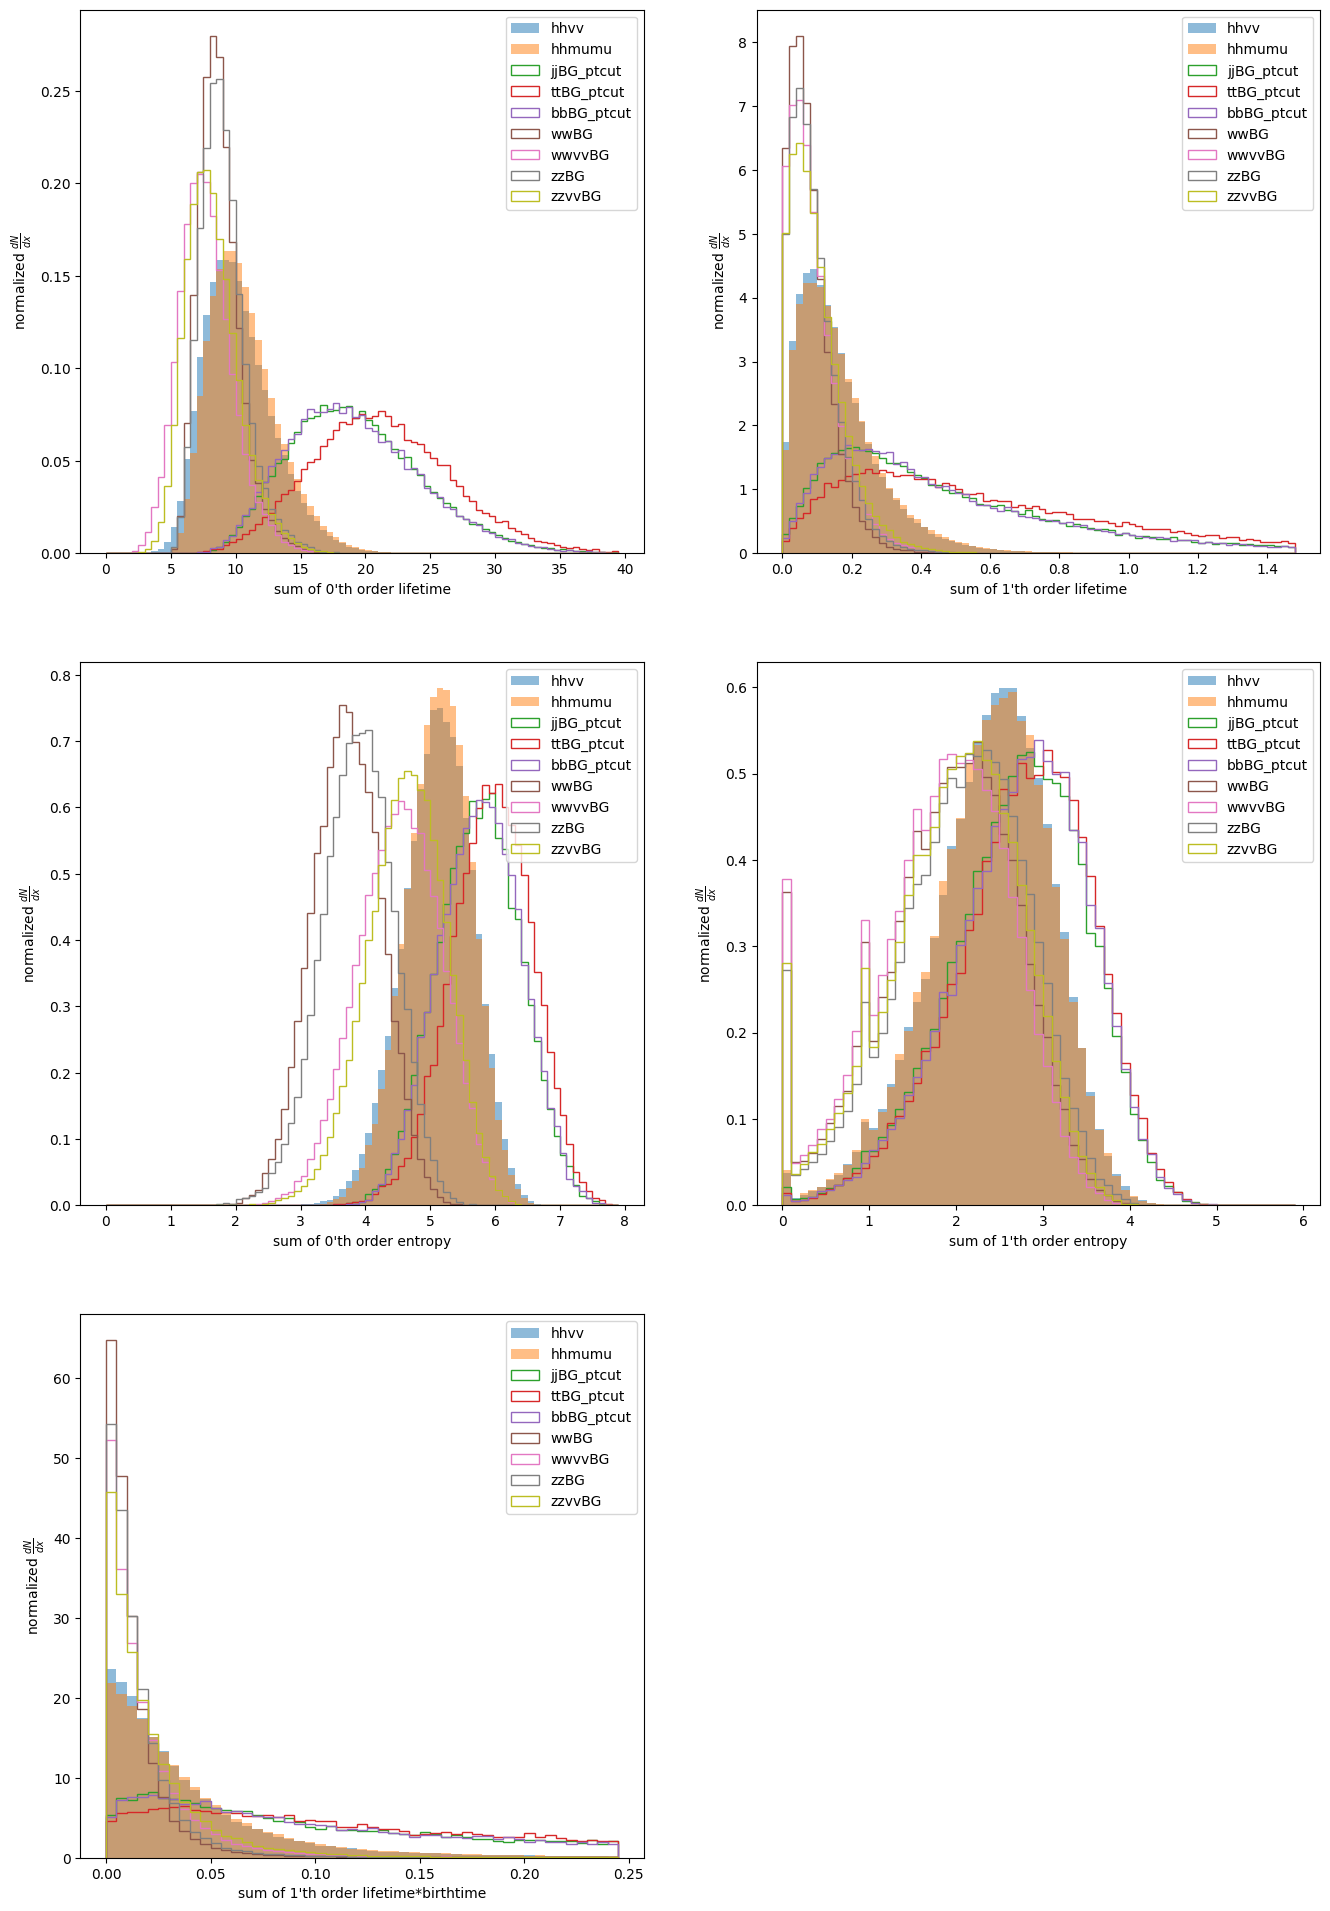

Time:2596.4855(s)


In [8]:
##### plot the histogram #####

fig = plt.figure(figsize=(16, 24))

fig.add_subplot(321)     ### plot H_0
bins = np.arange(0,40,0.5)
for process in processes:
    plt.hist(H_0[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"sum of 0'th order lifetime", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(322)     ### plot H_1
bins = np.arange(0,1.5,0.02)
for process in processes:
    plt.hist(H_1[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"sum of 1'th order lifetime", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(323)     ### plot S_0
bins = np.arange(0,8,0.1)
for process in processes:
    plt.hist(S_0[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"sum of 0'th order entropy", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(324)     ### plot S_1
bins = np.arange(0,6,0.1)
for process in processes:
    plt.hist(S_1[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"sum of 1'th order entropy", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(325)     ### plot LB_1
bins = np.arange(0,0.25,0.005)
for process in processes:
    plt.hist(LB_1[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"sum of 1'th order lifetime*birthtime", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

plt.show()

print("Time:{:^8.4f}(s)".format(time.time()-t1))